In [669]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.cross_validation import KFold
%matplotlib inline

In [1138]:
train = pd.read_csv("data/train.csv")
test  = pd.read_csv("data/test.csv")

In [1139]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [1140]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB


In [1141]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [1142]:
train = train[train.Age > 0]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    714 non-null int64
Survived       714 non-null int64
Pclass         714 non-null int64
Name           714 non-null object
Sex            714 non-null object
Age            714 non-null float64
SibSp          714 non-null int64
Parch          714 non-null int64
Ticket         714 non-null object
Fare           714 non-null float64
Cabin          185 non-null object
Embarked       712 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 72.5+ KB


In [1143]:
def clean_data(titanic):
    
    titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
    titanic["Fare"] = titanic["Fare"].fillna(titanic["Fare"].median())

    titanic = titanic.copy()
    
    titanic.Age = titanic.Age/titanic.Age.max()
    titanic.Fare = titanic.Fare/titanic.Fare.max()
    
    titanic.loc[titanic["Sex"] == "male", "Sex"] = -1
    titanic.loc[titanic["Sex"] == "female", "Sex"] = 1
    
    titanic['AgeSex'] = titanic.Age * titanic.Sex
    titanic['AgeSexFare'] = titanic.Age * titanic.Sex * titanic.Fare
    titanic['SexFare'] = titanic.Sex * titanic.Fare
#     titanic['FarePclass'] = titanic.Fare * titanic.Pclass
    
    titanic["Embarked"] = titanic["Embarked"].fillna("S")

    titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
    titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
    titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

    titanic["Fare"] = titanic["Fare"].fillna(titanic["Fare"].median())
    
    titanic["FamilySize"] = titanic['Parch'] + titanic['SibSp']
    
    titanic.drop(titanic[['Name', 'Ticket', 'Cabin']], axis = 1, inplace=True)

    return titanic

In [1144]:
df = clean_data(train)
df_train = clean_data(train)
df_train.drop('PassengerId', axis=1, inplace=True)
df_test  = clean_data(test)

In [1145]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
AgeSex         418 non-null object
AgeSexFare     418 non-null object
SexFare        418 non-null object
FamilySize     418 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 42.5+ KB


In [1146]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418,1100.500000,120.810458,892.000000,996.250000,1100.500000,1204.750000,1309
Pclass,418,2.265550,0.841838,1.000000,1.000000,3.000000,3.000000,3
Age,418,0.389464,0.167155,0.002237,0.302632,0.355263,0.470395,1
SibSp,418,0.447368,0.896760,0.000000,0.000000,0.000000,1.000000,8
Parch,418,0.392344,0.981429,0.000000,0.000000,0.000000,0.000000,9
Fare,418,0.069441,0.109012,0.000000,0.015412,0.028213,0.061429,1
FamilySize,418,0.839713,1.519072,0.000000,0.000000,0.000000,1.000000,10


In [1147]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,714,448.582633,259.119524,1.00000,222.250000,445.000000,677.750000,891
Survived,714,0.406162,0.491460,0.00000,0.000000,0.000000,1.000000,1
Pclass,714,2.236695,0.838250,1.00000,1.000000,2.000000,3.000000,3
Age,714,0.371239,0.181581,0.00525,0.251563,0.350000,0.475000,1
SibSp,714,0.512605,0.929783,0.00000,0.000000,0.000000,1.000000,5
Parch,714,0.431373,0.853289,0.00000,0.000000,0.000000,1.000000,6
Fare,714,0.067719,0.103291,0.00000,0.015713,0.030726,0.065144,1
FamilySize,714,0.943978,1.483788,0.00000,0.000000,0.000000,1.000000,7


In [1148]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeSex,AgeSexFare,SexFare,FamilySize
0,1,0,3,-1,0.2750,1,0,0.014151,0,-0.275,-0.00389154,-0.0141511,1
1,2,1,1,1,0.4750,1,0,0.139136,1,0.475,0.0660895,0.139136,1
2,3,1,3,1,0.3250,0,0,0.015469,0,0.325,0.00502729,0.0154686,0
3,4,1,1,1,0.4375,1,0,0.103644,0,0.4375,0.0453444,0.103644,1
4,5,0,3,-1,0.4375,0,0,0.015713,0,-0.4375,-0.00687424,-0.0157126,0


In [1149]:
y = df_train.pop('Survived').values
X = df_train.values
X_test = df_test.values

In [1150]:
rf = RandomForestClassifier(100)
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1151]:
feat_rank = np.argsort(rf.feature_importances_)[::-1]
feat_rank

array([ 7,  8,  9,  5,  2,  0,  1, 10,  3,  4,  6])

In [1152]:
df_train.columns[feat_rank]

Index([u'AgeSex', u'AgeSexFare', u'SexFare', u'Fare', u'Age', u'Pclass',
       u'Sex', u'FamilySize', u'SibSp', u'Parch', u'Embarked'],
      dtype='object')

In [1153]:
df_features = pd.DataFrame(rf.feature_importances_,df_train.columns, columns = ['feature_value'])

In [1154]:
df_features.sort_values('feature_value', ascending=False)

,feature_value
AgeSex,0.217764
AgeSexFare,0.199584
SexFare,0.169220
Fare,0.110557
Age,0.098721
Pclass,0.072773
Sex,0.039028
FamilySize,0.036247
SibSp,0.023558
Parch,0.017322


In [1155]:
features = [df_train.columns[feat_rank][x] for x in range(8)]
features

['AgeSex',
 'AgeSexFare',
 'SexFare',
 'Fare',
 'Age',
 'Pclass',
 'Sex',
 'FamilySize']

In [1136]:
def crossValidate(features, target, classifier, k_fold, r_state=None):

    # derive a set of (random) training and testing indices
    k_fold_indices = KFold(len(features), n_folds=k_fold,
                           shuffle=True, random_state=r_state)
    
    # for each set of training and testing indices 
    # train the classifier, and score the results
    k_score_total = 0
    for train_indices, test_indices in k_fold_indices :

        model = classifier.fit(features[train_indices],
                           target[train_indices])

        k_score = model.score(features[test_indices],
                              target[test_indices])

        k_score_total = k_score_total + k_score

    # return the average accuracy
    return k_score_total/k_fold

In [1137]:
for x in range (1,100,5):
    print crossValidate(X, y, RandomForestClassifier(x, min_samples_split=4,min_samples_leaf=2), 10, 0), x

0.76338028169 1
0.797046165884 6
0.816705790297 11
0.816607981221 16
0.829244913928 21
0.829264475743 26
0.820892018779 31
0.825078247261 36
0.816686228482 41
0.825058685446 46
0.825078247261 51
0.816666666667 56
0.830692488263 61
0.826486697966 66
0.822241784038 71
0.833509389671 76
0.825097809077 81
0.823708920188 86
0.820892018779 91
0.823669796557 96


In [1105]:
model = RandomForestClassifier(
#     random_state=1,
    n_estimators=50, 
#     min_samples_split=4,
#     min_samples_leaf=2
)

scores = cross_validation.cross_val_score(
    model,
    df[features],
    df["Survived"],
    cv=3
)

print(scores.mean())

0.761984231576


In [1156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Feature ranking:
1. feature 8 (0.259174)
2. feature 7 (0.205259)
3. feature 9 (0.121313)
4. feature 5 (0.099695)
5. feature 0 (0.085800)
6. feature 2 (0.079722)
7. feature 1 (0.059112)
8. feature 10 (0.041782)
9. feature 3 (0.021680)
10. feature 4 (0.013754)
11. feature 6 (0.012708)


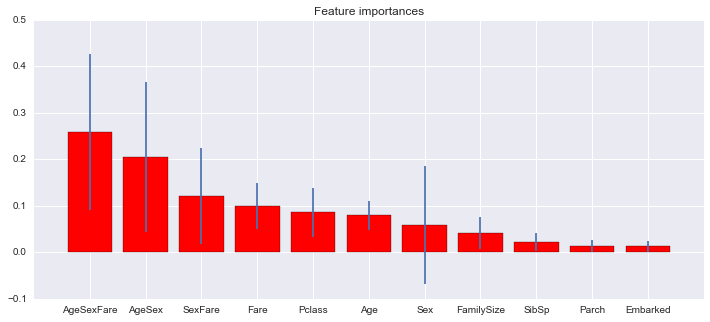

In [1157]:
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
# X, y = make_classification(n_samples=1000,
#                            n_features=10,
#                            n_informative=3,
#                            n_redundant=0,
#                            n_repeated=0,
#                            n_classes=2,
#                            random_state=0,
#                            shuffle=False)

# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=50, 
    min_samples_split=4,
    min_samples_leaf=2)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), df_train.columns[indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [1158]:
features

['AgeSex',
 'AgeSexFare',
 'SexFare',
 'Fare',
 'Age',
 'Pclass',
 'Sex',
 'FamilySize']

In [1167]:
def create_submission(model, train, test, predictors, filename):

    model.fit(train[features], train['Survived'])
    predictions = model.predict(test[features])

    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
    
    submission.to_csv(filename, index=False)

In [1168]:
create_submission(RandomForestClassifier(100, min_samples_split=4, min_samples_leaf=2), \
                  df, df_test, predictors, "submission.csv")

```
0.78469
['AgeSex', 'AgeSexFare', 'Fare', 'Age', 'Pclass', 'Sex']
create_submission(RandomForestClassifier(50, min_samples_split=4, min_samples_leaf=2), \
                  df, df_test, predictors, "submission.csv")
```

In [1169]:
features

['AgeSex',
 'AgeSexFare',
 'SexFare',
 'Fare',
 'Age',
 'Pclass',
 'Sex',
 'FamilySize']

In [906]:
create_submission(RandomForestClassifier(50, min_samples_split=4, min_samples_leaf=2), \
                  df, df_test, predictors, "submission.csv")

```
0.76555
['AgeSex', 'AgeSexFare', 'Fare', 'Age']
```

In [1163]:
trees_accuracy = []
for n_features in xrange(1,X.shape[1]):
    rf = RandomForestClassifier(100, max_features = n_features, min_samples_split=4, min_samples_leaf=2)
    rf.fit(X_train, y_train)
    trees_accuracy.append(rf.score(X_test,y_test))

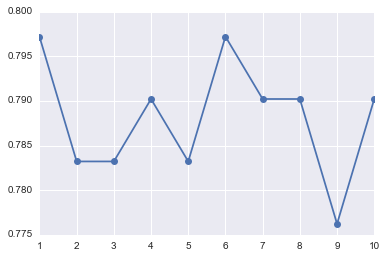

In [1164]:
plt.plot(range(1, X.shape[1]), trees_accuracy, '-o')